In [10]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl
from scipy.optimize import minimize

%matplotlib inline
%load_ext autoreload
%autoreload 2

parent_dir = '/scratch/users/vision/yu_dl/raaz.rsk/mdl_sim_may/may28_1/' # jun1 is 5-fold cv, may28_1 is LOOCV
save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)
folders = os.listdir(parent_dir)
print(folders)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['pmlb7', 'pmlb12', 'pmlb18', 'pmlb20', 'pmlb27', 'pmlb15', 'pmlb0', 'pmlb4', 'pmlb11', 'pmlb23', 'pmlb24', 'pmlb16', 'pmlb3', 'pmlb9', 'pmlb1', 'pmlb26', 'pmlb14', 'pmlb19', 'pmlb13', 'pmlb21', 'pmlb6', 'pmlb8', 'pmlb2', 'pmlb25', 'pmlb17', 'pmlb10', 'pmlb22', 'pmlb5']


# load results from a directory
**note - this script aggregates results - needs to be done to average across trials to make double descent curves**

In [ ]:
# !rm /scratch/users/vision/yu_dl/raaz.rsk/mdl_sim_may/may28_1/*/*processed*
!python postprocess.py

# figures

In [11]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

LABS = {
    'mdl_m10.0': 'MDL-COMP',
    'mdl_m1-1.0': 'MDL-COMP',
    'mdl_m1-5.0': 'MDL-COMP',    
    'ridge-1.0': 'Ridge-CV',
    'ridge-5.0': 'Ridge-CV',    
    'mdl_orig0.0': 'MDL-COMP-ORIG',
    'ols0.0': 'OLS'
}

**pmlb fig**

/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


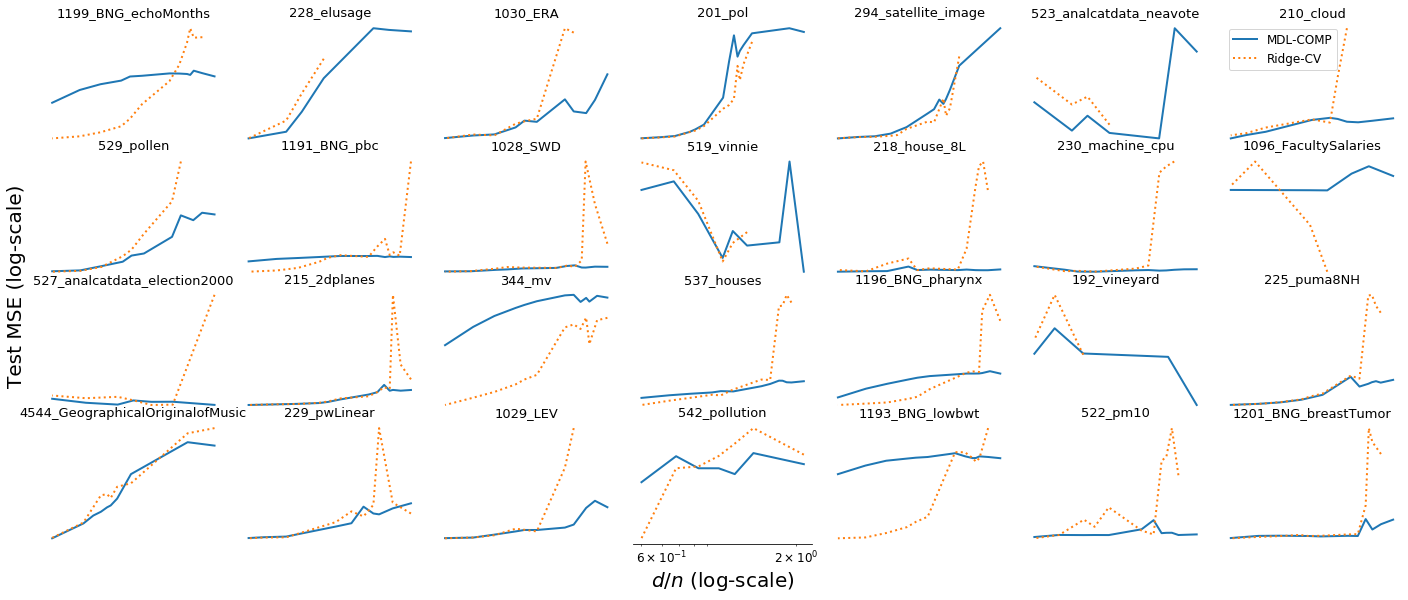

In [8]:
dfs_list = []
dsets = []
plot_all = False
R, C = 4, 7
# lets = ['A', 'B', 'C', 'D', 'E']
titles = {
    't': 'T-Distribution',
    'thresh': 'Thresholds',
    'decay': 'Decaying eigenvalues'
}
fig = plt.figure(figsize=(20, 8.5))
j = 0
for folder in folders: #, 'clustered', 'gaussian_scale_var']):
#     plt.title(lets[j], fontweight='bold', loc='left')    
    out_dir = oj(parent_dir, folder)
    df = pd.read_pickle(oj(out_dir, 'processed.pkl')).reset_index()
    dfs_list.append(df)
    dset_name = df['dset_name'].values[0]
    if dset_name not in data.REGRESSION_DSETS_LARGE_NAMES_RECOGNIZABLE:
        continue
    plt.subplot(R, C, j + 1)
#     plt.axhline(df.mse_zero.values[0], lw=4, color='gray', alpha=0.4, label='trivial')
    for i in range(df.shape[0]):
        curve = df.iloc[i]
    
        if curve.model_type == 'ridge' and curve.reg_param > 0:
            continue
        if curve.model_type == 'ols':
            continue
        l = str(curve.model_type) + str(curve.reg_param)
            

        if 'mdl' in curve.model_type:
            ls = '-'
        else:
            ls = ':'
        
        kwargs = {'label': LABS[l], 'alpha': 1, 'lw': 2, 'linestyle': ls}

    #     plt.plot(curve.ratio, curve.mse_test, 
        plt.plot(curve.ratio, curve.mse_test, **kwargs) #np.square(curve.bias) + curve['var'], **kwargs)
    if j == 0:
        plt.ylabel('Mean-squared error\n(test set)')
    plt.xlabel('d / n') #\n(Number of features / Number of training points)')
    plt.xscale('log')
    plt.yscale('log')

#     s = f'{model_type}_{dset}_{dset_name}+p={num_features}+lambda={reg_param}+noise_mult={noise_mult}'
    if j == C - 1:
        plt.legend()
    
    plt.title(dset_name, fontsize=13)
    plt.axis('off')
    j += 1

ax = plt.subplot(R, C, C * 2 + 1)    
plt.axis('on')
ax.set_yticks([])
plt.yscale('linear')
plt.ylabel('Test MSE (log-scale)', fontsize=20) #, labelpad=20) #, va='top')
ax.yaxis.set_label_coords(-0.1, 1.03)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_visible(False)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
ax.set_yticks([])



ax = plt.subplot(R, C, R * (C - 1) + C//2 - 2)
plt.xlabel('$d/n$ (log-scale)', fontsize=20)
plt.axis('on')
plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)
# plt.text(0, 1, 'Test MSE')

plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig(oj(save_dir, 'fig_pmlb_curves.pdf'))
# plt.show()


num satisfactory dsets 19


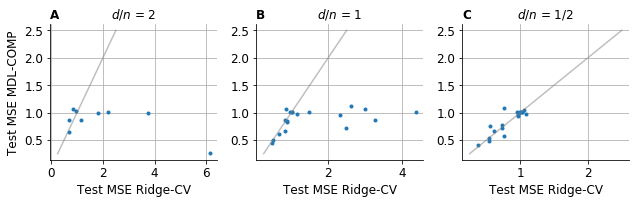

In [18]:
df_all_full = pd.concat(dfs_list)
print('num satisfactory dsets', int(df_all.shape[0]/3))
ratios = [2, 1, 1/2]
for ratio in ratios:
    def get_mse(row):
    #     print(row['ratio'], row['mse_test'])
        idxs = np.where(row['ratio']==ratio)[0]
        if len(idxs) == 0:
            return np.nan
        return row['mse_test'][idxs[0]]
    df_all_full[f'mse_{ratio:.2f}'] = df_all_full.apply(get_mse, axis=1)
df_all = df_all_full[df_all_full['num_features'] >= 6] # remove this to see the really small datasets

R, C = 1, 3
titles = ['2', '1', '1/2']
plt.figure(figsize=(9, 3))
lets = ['A', 'B', 'C']
for c in range(3):
    k = f'mse_{ratios[c]:.2f}'
    ax = plt.subplot(R, C, c + 1)
    plt.title(lets[c], loc='left', fontweight='bold')
    plt.plot(df_all[df_all['model_type']=='ridge'][k],
             df_all[df_all['model_type']=='mdl_m1'][k], '.')
    plt.xlabel('Test MSE Ridge-CV')
    plt.title('$d/n$ = ' + titles[c])
    if c == 0:
        plt.ylabel('Test MSE MDL-COMP')
    plt.plot([0.25, 2.5], [0.25, 2.5], color='gray', alpha=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.grid()
plt.tight_layout()
plt.savefig(oj(save_dir, 'fig_pmlb_5fold.pdf'))
plt.show()

# dataset statistics

**omit small dsets**

In [19]:
n_trains = []
n_feats = []
dset_names = sorted(df_all_full.dset_name.unique())
for name in tqdm(dset_names):
    dat = pmlb.fetch_data(name)
    n_trains.append(dat.shape[0])
    n_feats.append(dat.shape[1])

100%|██████████| 28/28 [00:27<00:00,  1.38it/s]


In [65]:
dd = df_all_full.sort_values('dset_name')
table = pd.DataFrame.from_dict({
    'Dataset name (OpenML ID)': dset_names,
    'Number of instances': n_trains,
    'Number of features': n_feats,
    'Ridge-CV MSE, $d/n=1$' : dd[dd.model_type.str.contains('ridge')]['mse_1.00'],
    'MDL-COMP MSE, $d/n=1$': vals,#dd[dd.model_type.str.contains('mdl_m1')]['mse_1.00']
})
print(table.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
         Dataset name (OpenML ID) &  Number of instances &  Number of features &  MSE when d/n = 1 (Selected by Ridge-CV) &  MSE when d/n = 1 (Selected by MDL-COMP) \\
\midrule
                         1028\_SWD &                 1000 &                  11 &                                 1.166937 &                                 0.971250 \\
                         1029\_LEV &                 1000 &                   5 &                                      NaN &                                 1.101220 \\
                         1030\_ERA &                 1000 &                   5 &                                      NaN &                                 1.048269 \\
             1096\_FacultySalaries &                   50 &                   5 &                                      NaN &                                 2.012835 \\
                     1191\_BNG\_pbc &              1000000 &                  19 &                                 